In [1]:
import data_smoothing
import find_peaks
import peak_character
import peak_classify

# Load real TA data

In [3]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp03_20180103 -t0 -chirp.csv')

# Smoothen data

In [4]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


# Find peaks

In [5]:
threshold = 0
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

# convert peak index to nm

In [9]:
import numpy as np
idx_np = np.nan_to_num(np.array(idx))

peak1 = np.empty(len(data_time))
peak2 = np.empty_like(peak1)
for i in range(np.shape(idx_np)[0]):
    peak1[i] = data_nm[int(idx_np[:, 0][i])]
    peak2[i] = data_nm[int(idx_np[:, 1][i])]

In [10]:
import remove_outlier as outlier
import matplotlib.pyplot as plt

In [19]:
peak1_corr = outlier.id_outliers_replacewith_interp(data_time, peak1, 1, 50)

15


In [21]:
peak1_isotonic = outlier.isotonic(data_time, peak1_corr)

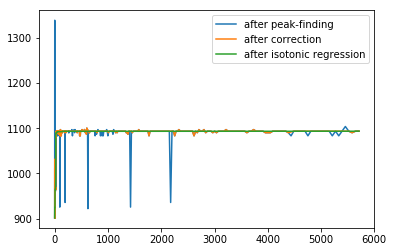

In [23]:
plt.figure()

plt.plot(data_time, peak1, label = 'after peak-finding')
plt.plot(data_time, peak1_corr, label = 'after correction')
plt.plot(data_time, peak1_isotonic, label = 'after isotonic regression')
plt.legend()

In [34]:
corrected_output = peak_classify.data_grouping(idx, height, fwhm)

In [35]:
peak_dict = peak_classify.cluster_classifier(idx, corrected_output)

# peak #2

In [24]:
peak2_corr = outlier.id_outliers_replacewith_interp(data_time, peak2, 1, 100)

7


In [25]:
peak2_isotonic = outlier.isotonic(data_time, peak2_corr)

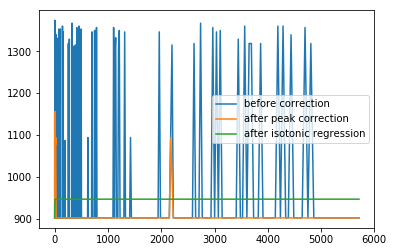

In [26]:
plt.figure()
plt.plot(data_time, peak2, label = 'before correction')
plt.plot(data_time, peak2_corr, label = 'after peak correction')
plt.plot(data_time, peak2_isotonic, label = 'after isotonic regression')
plt.legend()